<a href="https://colab.research.google.com/github/john-reilly/RoboFarm/blob/master/Apples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#!ls

#!ls  '/content/gdrive/My Drive/'
base_dir = '/content/gdrive/My Drive/'

In [3]:
#REQUIREMENTS 
!Flask==0.11.1
!attrdict==2.0.0
!eventlet==0.19.0
!python-socketio==1.6.1 #not found
!numpy==1.13.1
!scipy==0.19.1
!keras==2.0.8
!tensorflow==1.3.0
!h5py==2.6.0
!pandas==0.24.2
!scikit-learn==0.20.3 #not found
!Pillow==2.8.0
!pathlib2 #not found

/bin/bash: python-socketio==1.6.1: command not found
/bin/bash: scikit-learn==0.20.3: command not found
/bin/bash: pathlib2: command not found


In [0]:
import os
import random
import time

import tensorflow as tf
import numpy as np
from PIL import Image, ImageOps


class ObjectClassifier:

    def __init__(self):
        # constants
        self.OBJECT_DETECTION_CLASS = 53 #from COCO dataset 53 is an annple 10 is a traffic light see more here https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/
        self.DETECTION_THRESHOLD = 0.09  ##80% fine for single apple image but score s on appleing in vidoe frame mych lower0.8# 0.8#0.3

        # init object classifier (step 1)
        #cwd = os.path.dirname(os.path.realpath(__file__)) #it does n't like __file__ maybe because not imported?
        self.detection_graph = tf.Graph()
        with self.detection_graph.as_default():
            od_graph_def = tf.GraphDef()
            try:
                with tf.gfile.GFile( base_dir + 'frozen_inference_graph.pb', 'rb') as fid:#cwd + '/models/frozen_inference_graph.pb', 'rb') as fid:
                    serialized_graph = fid.read()
                    od_graph_def.ParseFromString(serialized_graph)
                    tf.import_graph_def(od_graph_def, name='')
                    self.session = tf.Session(graph=self.detection_graph)
            except Exception as e:
                print(e)
                exit()

    #def get_traffic_light_images(self, image, probability_level):
    def get_objects(self, image, probability_level):
        output_dict = self.run_inference_for_single_image(image)
        #return self.extract_image_from_boxes(image, output_dict,probability_level)
        return output_dict, self.extract_image_from_boxes(image, output_dict,probability_level)

        #return self.overlay_bounding_boxes(image, output_dict,probability_level)

    def run_inference_for_single_image(self, image):
        # Get handles to input and output tensors
        ops = self.detection_graph.get_operations()
        all_tensor_names = {output.name for op in ops for output in op.outputs}
        tensor_dict = {}
        for key in [
            'num_detections', 'detection_boxes', 'detection_scores', 'detection_classes'
        ]:
            tensor_name = key + ':0'
            if tensor_name in all_tensor_names:
                tensor_dict[key] = self.detection_graph.get_tensor_by_name(
                    tensor_name)
        image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0')

        # Run inference
        start = time.time()
        output_dict = self.session.run(tensor_dict,
                               feed_dict={image_tensor: np.expand_dims(image, 0)})
        elapsed = time.time() - start
        print('inference took:', elapsed, ' seconds') #was commented out
        
        # all outputs are float32 numpy arrays, so convert types as appropriate
        output_dict['num_detections'] = int(output_dict['num_detections'][0])
        #john
        print("num_detections:" , output_dict['num_detections'])#john
        output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
        #john
        print(output_dict['detection_classes'])
        output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
        output_dict['detection_scores'] = output_dict['detection_scores'][0]
        #
        #print(" output_dict['detection_boxes']  " , output_dict['detection_boxes'])
        print(" output_dict['detection_scores'] " , output_dict['detection_scores'])

        return output_dict

    def extract_image_from_boxes(self, image, output_dict ,probability_level):
        self.DETECTION_THRESHOLD =  probability_level #self.DETECTION_THRESHOLD is from original version and in init
        
        classes = output_dict['detection_classes']
        boxes = output_dict['detection_boxes']
        scores = output_dict['detection_scores']

        height, width, _ = image.shape

        tf_boxes = []
        output_images = []
        for i in range(len(boxes)):
            confidence = float(scores[i])
            ymin, xmin, ymax, xmax = tuple(boxes[i].tolist())
            ymin = int(ymin * height)
            ymax = int(ymax * height)
            xmin = int(xmin * width)
            xmax = int(xmax * width)
            box_width = xmax - xmin
            box_height = ymax - ymin
            box_ratio = float(box_height) / box_width # ration maybe the problem
            if confidence >= self.DETECTION_THRESHOLD and \
               classes[i] == self.OBJECT_DETECTION_CLASS :#and \
               #box_width > 21 and \
               #box_height > 20 : # and \
               #box_ratio > 1.5:
                tf_boxes.append(boxes[i])
                crop_image = image[ymin:ymax, xmin:xmax]
                crop_output_image = Image.fromarray(crop_image)
                output_images.append(crop_output_image)

        print('Outputimages len:' , len(output_images))
        return output_images



    def overlay_bounding_boxes(self, image, output_dict, probability_level, preditions):
        classes = output_dict['detection_classes']
        boxes = output_dict['detection_boxes']
        scores = output_dict['detection_scores']

        height, width, _ = image.shape

        tf_boxes = []
        output_images = []
        for i in range(len(boxes)):
            confidence = float(scores[i])
            ymin, xmin, ymax, xmax = tuple(boxes[i].tolist())
            ymin = int(ymin * height)
            ymax = int(ymax * height)
            xmin = int(xmin * width)
            xmax = int(xmax * width)
            box_width = xmax - xmin
            box_height = ymax - ymin
            #below was  if confidence >= self.DETECTION_THRESHOLD
            if confidence >= 0.10   and \
            classes[i] == self.OBJECT_DETECTION_CLASS : #and \
               #box_width > 21 and \
               #box_height > 20 : # and \
               #box_ratio > 1.5:
            #was in if
              tf_boxes.append(boxes[i])
              cv2.rectangle(image, (xmin,ymin) , (xmax, ymax) , (255,0,0) ,2)
                
              font = cv2.FONT_HERSHEY_DUPLEX  # color
                
              cv2.putText(image, 'Ripe', (xmax - 100, ymax), font, 1.0, (255, 0, 0), 2)
          

        #print('Outputimages len:' , len(output_images))
        #return output_images
        return image



In [0]:
import os
import time
import calendar

import tensorflow as tf
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from PIL import Image, ImageOps
import numpy as np

import cv2



class TLClassifier(object):
    #john  added boolean is_site to indicate site or sim classifer to load
    def __init__(self, is_site): 
        # init object classifier (step 1)
    
        self.object_classifier = ObjectClassifier()
        self.RECORD_CROPPED_IMAGES = False #True#False

    def get_classification(self, image , probability_level):
        """Determines the color of the traffic light in the image
        Args:
            image (cv::Mat): image containing the traffic light
        Returns:
            int: 
        """
    
        # convert from bgr 2 rgb
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # step 1
        #traffic_light_images = self.object_classifier.get_traffic_light_images(image)
        #image_with_bounding_boxes = self.object_classifier.get_objects(image, probability_level)
        #detected_objects = self.object_classifier.get_objects(image, probability_level)
        output_dict , detected_objects = self.object_classifier.get_objects(image, probability_level)
        
        #traffic_light_color = self.color_classifier.predict_images(traffic_light_images)

        #tf_color = ['RED', 'YELLOW', 'GREEN', 'UNDEFINED', 'UNKNOWN'] # Not so nice ;-( but want to show text
        #rospy.loginfo('Traffic light detected {}'.format(tf_color[traffic_light_color]))

        if self.RECORD_CROPPED_IMAGES:
            dir = base_dir + '/data/cropped/'
            if not os.path.exists(dir):
                os.makedirs(dir)

            for idx, image in enumerate(image_with_bounding_boxes):#traffic_light_images):
                #f_name = "sim_tl_{}_{}_{}.jpg".format(calendar.timegm(time.gmtime()), tf_color[traffic_light_color], idx)
                f_name =  "detected_cropped_{}_{}.JPG".format(calendar.timegm(time.gmtime()), idx)
                image.save(dir + f_name)

        #return traffic_light_color
        #return
        #return image_with_bounding_boxes
        #return detected_objects
        return output_dict, detected_objects

In [0]:
from keras.models import load_model
from keras.preprocessing.image import img_to_array, load_img
import numpy as np
from PIL import Image, ImageOps
import os
#import rospy
import tensorflow as tf

#from styx_msgs.msg import TrafficLight # for traffic light colour values

class ColorClassifier:
    def __init__(self, is_site):
        self.IMAGE_SIZE = 32
        cwd = os.path.dirname(os.path.realpath(__file__))
        if is_site:
            self.class_model = load_model(cwd + '/models/model_site.h5')
        else:
            self.class_model = load_model(cwd + '/models/model_sim.h5')
            
        self.class_graph = tf.get_default_graph()

    def predict_image(self, image):
        x = self.crop_image(image)
        x = img_to_array(x)
        x = np.expand_dims(x, axis=0)
        with self.class_graph.as_default():
            preds = self.class_model.predict_classes(x)
            prob = self.class_model.predict_proba(x)

        return preds[0], prob[0]

    def predict_images(self, images):
        predictions = []
        for image in images:
            pred, prob = self.predict_image(image)
            rospy.loginfo('Color pred {} with prob {}'.format(pred, prob)) #john added {} here missing?
            predictions.append(pred)
            # force a return on detection of even one red
            if (pred == 0): return TrafficLight.RED
            
        if len(predictions) > 0:
            prediction = max(predictions, key=predictions.count)
            if prediction == 3:
                return TrafficLight.UNKNOWN
            else:
                return prediction
        else:
            return TrafficLight.UNKNOWN

    def crop_image(self, img):
        img.thumbnail((self.IMAGE_SIZE, self.IMAGE_SIZE), Image.ANTIALIAS)
        width, height = img.size
        delta_w = self.IMAGE_SIZE - width
        delta_h = self.IMAGE_SIZE - height
        padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))
        img = ImageOps.expand(img, padding, fill=0)  # fill with black dots

        return img

In [43]:
#TRAIN.py
# Load the data

import gzip
import re
import os

import numpy as np
import pandas as pd
from time import time
from PIL import Image, ImageOps

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard
from keras.preprocessing.image import array_to_img, img_to_array, load_img
#from keras.backend import tf as ktf
from keras.backend import tensorflow_backend as ktf

#from pathlib2 import Path  # python 2 backport #didn't like this in colab
from pathlib import Path

from os import listdir
from os.path import isfile, join

#traffic_light_colors = ['red', 'yellow', 'green', 'unknown']
apple_type = ['ripe', 'not_ripe']
apple_type_categories = [[1,0], [0,1]]

RESIZED_DIR = base_dir + 'data/' + 'Ripe_not_ripe/' + 'images_resized/'

def read_images(images_path):
    labels = []
    features = []
    for root, dirs, files in os.walk(images_path, topdown=False):
        print( 'root: ' , root , 'dirs: ' , dirs , 'files:' , files )
        #path = os.path.dirname(RESIZED_DIR + root + '/')
        path = os.path.dirname(images_path + 'images_resized/')
        #print("line 42")
        Path(path).mkdir(exist_ok=True)
        print("line 45")
        for filename in files:
            added = False
            print('line 48')
            for index, color in enumerate(apple_type):
                print('line 50')
                #if below removed
                #if filename.find(color) != -1: #my files are not ripe or not_ripe but camera files names
                
                labels.append(apple_type_categories[index])
                print('line 55')
                print(filename)
                #No such file or directory: '/content/gdrive/My Drive/data/Ripe_not_ripe/DSCF4576.JPG'
                #img = load_img(root + '/' + filename)  # this is a PIL image
                print(images_path + apple_type[index]+ '/' + filename)
                img = load_img(images_path + apple_type[index]+ '/' + filename)
                img = crop_image(img)
                print('line 62')
                #img.save('{}{}{}.jpeg'.format(RESIZED_DIR, root + '/', remove_ext(filename)), 'JPEG')
                #img.save('{}{}{}.jpeg'.format(RESIZED_DIR,  apple_type[index]+ '/' ,remove_ext(filename)), 'JPEG')
                img.save('{}{}{}'.format(RESIZED_DIR,  apple_type[index]+ '/' ,filename), 'JPEG')
                x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150) #john 32*32 ?
                features.append(x)

                added = True
                break
            if not added:
                print('Error invalid filename:', filename)

    return np.array(features), np.array(labels)

def preprocess_images(images_path):
  
  #(base_dir + 'data/' + 'Ripe_not_ripe/')
    if not os.path.exists(images_path + 'preprocessed/' + 'ripe/' ):
      os.makedirs(images_path + 'preprocessed/' + 'ripe/' )
  
    for root, dirs, files in os.walk(images_path+'ripe/', topdown=True):    
      for filename in files:
        img = load_img(images_path + 'ripe/' + filename)
        img = crop_image(img)
        img.save(images_path + 'preprocessed/' + 'ripe/' + filename)


    if not os.path.exists(images_path + 'preprocessed/' + 'not_ripe/' ):
      os.mkdir(images_path + 'preprocessed/' + 'not_ripe/' )

    for root, dirs, files in os.walk(images_path+'not_ripe/', topdown=True):    
      for filename in files:
        img = load_img(images_path + 'not_ripe/' + filename)
        img = crop_image(img)
        img.save(images_path + 'preprocessed/' + 'not_ripe/' + filename)


def load_prepared_images(images_path):
  
  features = []
  labels = []

  for root, dirs, files in os.walk(images_path+'ripe/', topdown=True):    
    for filename in files:
      img = load_img(images_path + 'ripe/' + filename)
      x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150) #john 32*32 ?
      features.append(x)
      #labels.append('ripe')
      #apple_type_categories = [[1,0], [0,1]]
      labels.append(apple_type_categories[0])


  for root, dirs, files in os.walk(images_path+'not_ripe/', topdown=True):    
    for filename in files:
      img = load_img(images_path + 'not_ripe/' + filename)
      x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150) #john 32*32 ?
      features.append(x)
      #labels.append('not_ripe')
      #apple_type_categories = [[1,0], [0,1]]
      labels.append(apple_type_categories[1])
     


  return np.array(features), np.array(labels)




def remove_ext(filename):
    return re.sub(r'\.png|\.jpeg|\.jpg', '', filename, re.IGNORECASE)

def crop_image(img):
    img.thumbnail((32, 32), Image.ANTIALIAS)
    width, height = img.size
    delta_w = 32 - width
    delta_h = 32 - height
    padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))
    img = ImageOps.expand(img, padding, fill=0)  # fill with black dots
    return img


#features, labels = read_images('images')
#features, labels = read_images(base_dir + 'data/' + 'Ripe_not_ripe/')

#preprocess_images(base_dir + 'data/' + 'Ripe_not_ripe/')

features, labels = load_prepared_images(base_dir + 'data/' + 'Ripe_not_ripe/' + 'preprocessed/')


train = {}
test = {}

train['features'], test['features'], train['labels'], test['labels'] = train_test_split(features, labels, test_size=0.05)

# explore the data

print('# of training images:', train['features'].shape[0])
print('# of test images:', test['features'].shape[0])

# plot training data
train_labels_count = np.unique(train['labels'], return_counts=True)
dataframe_train_labels = pd.DataFrame({'Label':train_labels_count[0], 'Count':train_labels_count[1]})
print(dataframe_train_labels)

# Split training data into training and validation
validation = {}
train['features'], validation['features'], train['labels'], validation['labels'] = train_test_split(train['features'], train['labels'], test_size=0.2, random_state=0)

print('# of training images:', train['features'].shape[0])
print('# of validation images:', validation['features'].shape[0])

print(features.shape)
print(labels.shape)

print("Updated Image Shape: {}".format(train['features'][0].shape))

model = Sequential()

model.add(layers.Lambda(lambda x: x/255.0 - 0.5, input_shape=(32,32,3))) # added

model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)))
model.add(layers.AveragePooling2D())

model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(layers.AveragePooling2D())

model.add(layers.Flatten())

model.add(layers.Dense(units=120, activation='relu'))

model.add(layers.Dense(units=84, activation='relu'))

#model.add(layers.Dense(units=4, activation = 'softmax'))
model.add(layers.Dense(units=2, activation = 'softmax')) #for 2 categories

model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
model.fit(train['features'], train['labels'], epochs=52, validation_split=0.3, shuffle=True, callbacks=[tensorboard])

# EPOCHS = 10
# BATCH_SIZE = 128

# X_train, y_train = train['features'], train['labels']
# X_validation, y_validation = validation['features'], validation['labels']

# train_generator = ImageDataGenerator().flow(X_train, y_train, batch_size=BATCH_SIZE)
# validation_generator = ImageDataGenerator().flow(X_validation, y_validation, batch_size=BATCH_SIZE)

# print('# of training images:', train['features'].shape[0])
# print('# of validation images:', validation['features'].shape[0])

# steps_per_epoch = X_train.shape[0]//BATCH_SIZE
# validation_steps = X_validation.shape[0]//BATCH_SIZE

# tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
# model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
#                     validation_data=validation_generator, validation_steps=validation_steps,
#                     shuffle=True, callbacks=[tensorboard])

score = model.evaluate(test['features'], test['labels'])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

#model.save('model/model.h5')
model.save(base_dir + 'apple_lenet_model.h5')

# of training images: 243
# of test images: 13
   Label  Count
0      0    243
1      1    243
# of training images: 194
# of validation images: 49
(256, 32, 32, 3)
(256, 2)
Updated Image Shape: (32, 32, 3)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 6)         168       
_________________________________________________________________
average_pooling2d_3 (Average (None, 15, 15, 6)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 16)        880       
_________________________________________________________________
average_pooling2d_4 (Average (None, 6, 6, 16)          0         
_____________________________________________

DSCF4560.JPG : ripe - prodb: [9.9983132e-01 1.6860176e-04] -elapsed time: 0.40564846992492676  s


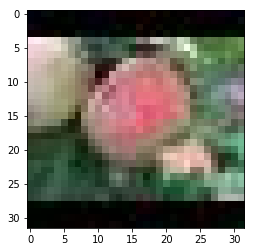

correct
DSCF4561.JPG : ripe - prodb: [9.9999046e-01 9.5212263e-06] -elapsed time: 0.006921291351318359  s


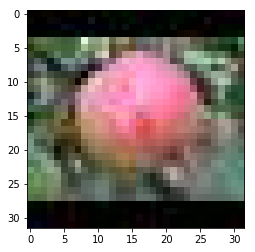

correct
DSCF4571.JPG : ripe - prodb: [9.9998510e-01 1.4916132e-05] -elapsed time: 0.015672922134399414  s


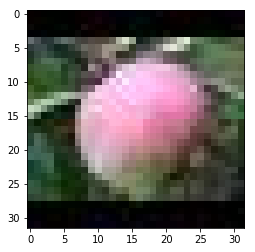

correct
DSCF4576.JPG : ripe - prodb: [9.9986398e-01 1.3597486e-04] -elapsed time: 0.014371156692504883  s


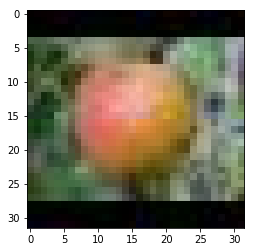

correct
DSCF4577.JPG : ripe - prodb: [9.9955899e-01 4.4098694e-04] -elapsed time: 0.006732940673828125  s


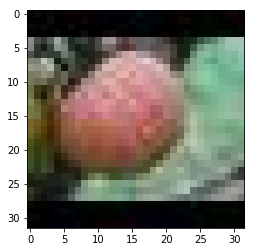

correct
DSCF4589.JPG : ripe - prodb: [9.9996257e-01 3.7399914e-05] -elapsed time: 0.010596275329589844  s


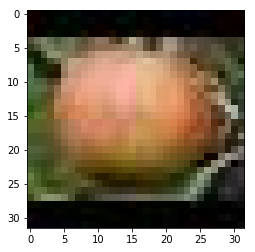

correct
DSCF4590.JPG : ripe - prodb: [9.999621e-01 3.789156e-05] -elapsed time: 0.0077669620513916016  s


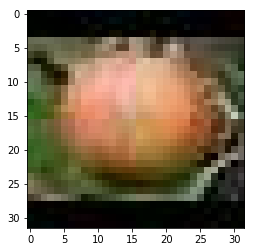

correct
DSCF4591.JPG : ripe - prodb: [9.990945e-01 9.055315e-04] -elapsed time: 0.007102012634277344  s


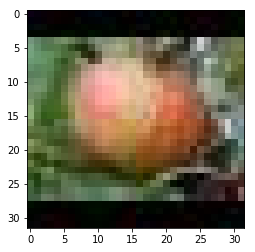

correct
DSCF4624.JPG : ripe - prodb: [0.99848735 0.00151267] -elapsed time: 0.00786590576171875  s


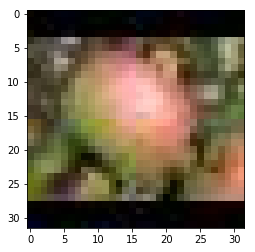

correct
DSCF4625.JPG : ripe - prodb: [9.9997735e-01 2.2701041e-05] -elapsed time: 0.007172107696533203  s


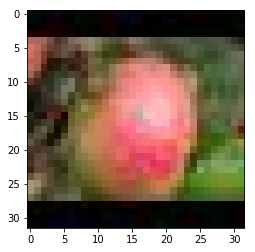

correct
DSCF4626.JPG : ripe - prodb: [9.9999547e-01 4.5047859e-06] -elapsed time: 0.007417440414428711  s


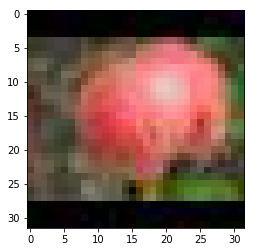

correct
DSCF4627.JPG : ripe - prodb: [9.9997163e-01 2.8412562e-05] -elapsed time: 0.007538557052612305  s


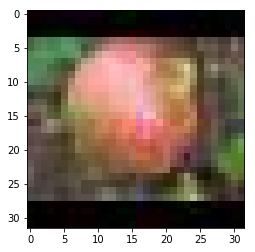

correct
DSCF4641.JPG : ripe - prodb: [0.9932688  0.00673123] -elapsed time: 0.00797128677368164  s


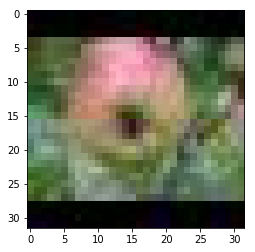

correct
DSCF4652.JPG : ripe - prodb: [0.9963476  0.00365247] -elapsed time: 0.0074253082275390625  s


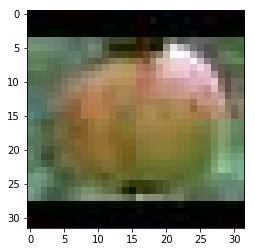

correct
DSCF4653.JPG : ripe - prodb: [9.9995041e-01 4.9547132e-05] -elapsed time: 0.007672786712646484  s


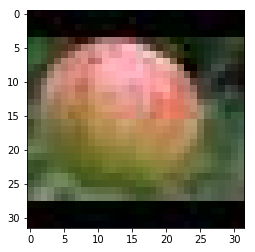

correct
DSCF4670.JPG : ripe - prodb: [9.9998248e-01 1.7562852e-05] -elapsed time: 0.008475780487060547  s


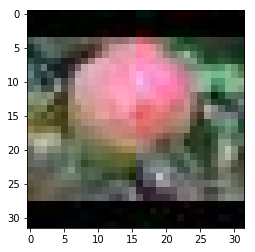

correct
DSCF4671.JPG : ripe - prodb: [9.999933e-01 6.619111e-06] -elapsed time: 0.013219594955444336  s


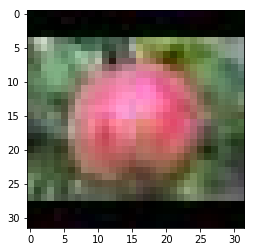

correct
DSCF4672.JPG : ripe - prodb: [9.9990404e-01 9.6013391e-05] -elapsed time: 0.011884689331054688  s


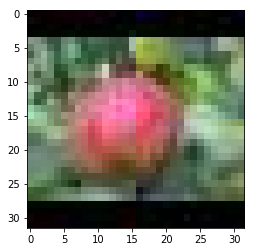

correct
DSCF4673.JPG : ripe - prodb: [9.997366e-01 2.633955e-04] -elapsed time: 0.013204097747802734  s


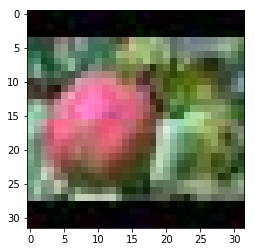

correct
DSCF4674.JPG : ripe - prodb: [9.9989319e-01 1.0685139e-04] -elapsed time: 0.005560636520385742  s


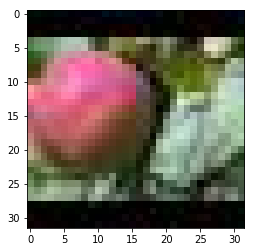

correct
DSCF4675.JPG : ripe - prodb: [9.9996555e-01 3.4480847e-05] -elapsed time: 0.0055217742919921875  s


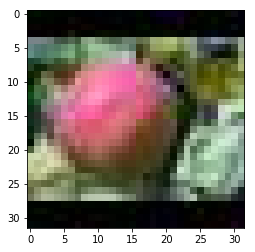

correct
DSCF4962.JPG : ripe - prodb: [9.9999225e-01 7.7481309e-06] -elapsed time: 0.010062456130981445  s


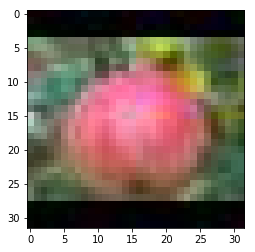

correct
DSCF4963.JPG : ripe - prodb: [9.9999595e-01 4.0973241e-06] -elapsed time: 0.0075397491455078125  s


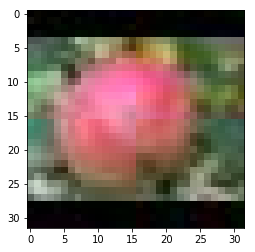

correct
DSCF4964.JPG : ripe - prodb: [9.9999702e-01 3.0040633e-06] -elapsed time: 0.008929014205932617  s


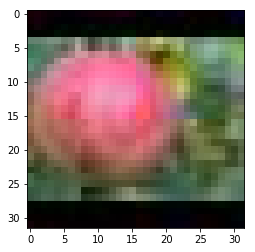

correct
DSCF4965.JPG : ripe - prodb: [9.9999702e-01 2.9541209e-06] -elapsed time: 0.005802154541015625  s


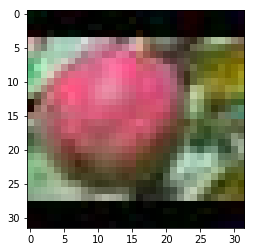

correct
DSCF4966.JPG : ripe - prodb: [9.9998772e-01 1.2234257e-05] -elapsed time: 0.006252288818359375  s


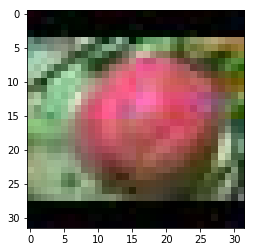

correct
DSCF4977.JPG : ripe - prodb: [9.999157e-01 8.424840e-05] -elapsed time: 0.006511211395263672  s


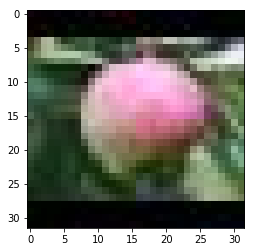

correct
DSCF4978.JPG : ripe - prodb: [9.99894857e-01 1.05128594e-04] -elapsed time: 0.006573677062988281  s


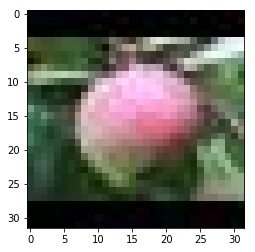

correct
DSCF4979.JPG : ripe - prodb: [9.996648e-01 3.351903e-04] -elapsed time: 0.0065119266510009766  s


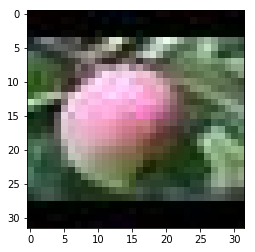

correct
DSCF5011.JPG : ripe - prodb: [9.9941778e-01 5.8221037e-04] -elapsed time: 0.006969451904296875  s


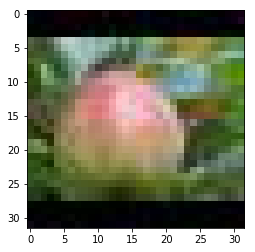

correct
DSCF5012.JPG : ripe - prodb: [0.9721201  0.02787991] -elapsed time: 0.006421089172363281  s


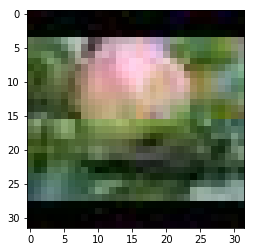

correct
DSCF5013.JPG : ripe - prodb: [0.9963481  0.00365197] -elapsed time: 0.006389141082763672  s


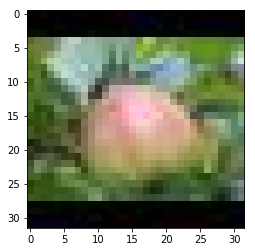

correct
DSCF5014.JPG : ripe - prodb: [9.994374e-01 5.625394e-04] -elapsed time: 0.006291389465332031  s


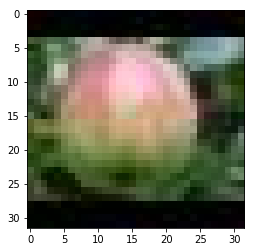

correct
DSCF5047.JPG : ripe - prodb: [0.9960944 0.0039056] -elapsed time: 0.012031078338623047  s


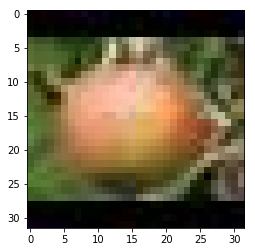

correct
DSCF5048.JPG : ripe - prodb: [0.9576538  0.04234612] -elapsed time: 0.007233381271362305  s


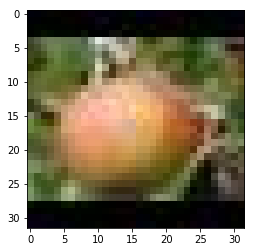

correct
DSCF5049.JPG : ripe - prodb: [0.74176794 0.258232  ] -elapsed time: 0.006499528884887695  s


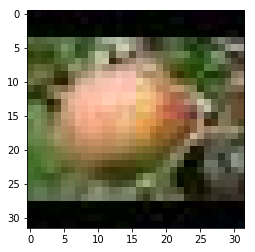

correct
DSCF5050.JPG : not_ripe - prodb: [0.26267558 0.7373244 ] -elapsed time: 0.006413459777832031  s


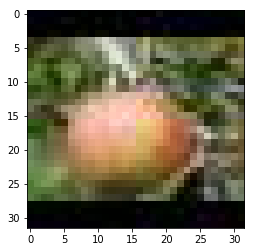

not correct
errors: 1 (2.7027027027027026 %) out of 37


In [44]:
#classify.py

import numpy as np
from keras.models import load_model
from keras.preprocessing.image import img_to_array, load_img
import time
import os
#model.save(base_dir + 'apple_lenet_model.h5')
#class_model = load_model('model'+ '/model.h5')
class_model = load_model(base_dir + 'apple_lenet_model.h5')

#traffic_light_colors = ['red', 'yellow', 'green', 'unknown']
traffic_light_colors = ['ripe', 'not_ripe']

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def predict(image_name):
   

    img = load_img(image_name, False, target_size=(32, 32))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    preds = class_model.predict_classes(x)
    prob = class_model.predict_proba(x)

    return preds[0], prob[0]

def predict_for_detected(image_name):
   

    #img = load_img(image_name, False, target_size=(32, 32))
    #x = img_to_array(img)
    #resized_image = tf.image.resize_images( image_name,(32,32),    method=ResizeMethodV1.BILINEAR,    align_corners=False,    preserve_aspect_ratio=False, name=None   )

    resized_image = image_name.resize((32,32), resample=0)

    x = img_to_array(resized_image)
    x = np.expand_dims(x, axis=0)
    preds = class_model.predict_classes(x)
    prob = class_model.predict_proba(x)

    return preds[0], prob[0]

total = 0
errors = 0
#for root, dirs, files in os.walk("images_resized/images/green", topdown=False):
for root, dirs, files in os.walk( base_dir + 'data/Ripe_not_ripe/preprocessed/ripe/', topdown=False):
    for filename in files:
        start = time.time()
        #pred, prob = predict(root + '/' + filename)
        #pred, prob = predict(root + filename)
        pred, prob = predict( base_dir + 'data/Ripe_not_ripe/preprocessed/ripe/' + filename)
        #print('root' , root)
        #print(root + '/' + filename)
        elapsed = time.time() - start
        print(filename, ':', traffic_light_colors[pred], '- prodb:', prob, '-elapsed time:', elapsed, ' s')
        total += 1
       
        img=mpimg.imread( base_dir + 'data/Ripe_not_ripe/preprocessed/ripe/' + filename)
        imgplot = plt.imshow(img)
        plt.show()
        #if filename.find(traffic_light_colors[pred]) == -1:
        if traffic_light_colors[pred] ==  'not_ripe':
            print('not correct')
            errors += 1
            
        else:
            print('correct')

print('errors: {} ({} %) out of {}'.format(errors, 100 * errors / total, total))

In [0]:
for root, dirs, files in os.walk( base_dir + 'data/cropped/', topdown=False):
    for filename in files:
        start = time.time()
        pred, prob = predict( base_dir + 'data/cropped/' + filename)

        elapsed = time.time() - start
        print(filename, ':', traffic_light_colors[pred], '- prodb:', prob, '-elapsed time:', elapsed, ' s')
  
       
        img=mpimg.imread( base_dir + 'data/cropped/' + filename)
        imgplot = plt.imshow(img)
        plt.show()
      

In [0]:
#@title

pred, prob = predict(  base_dir + 'data/cropped/' +'ripe_test.JPG')
 
img=mpimg.imread(  base_dir + 'data/cropped/' +'ripe_test.JPG')
imgplot = plt.imshow(img)
plt.show()
        
print( traffic_light_colors[pred], '- prodb:', prob )

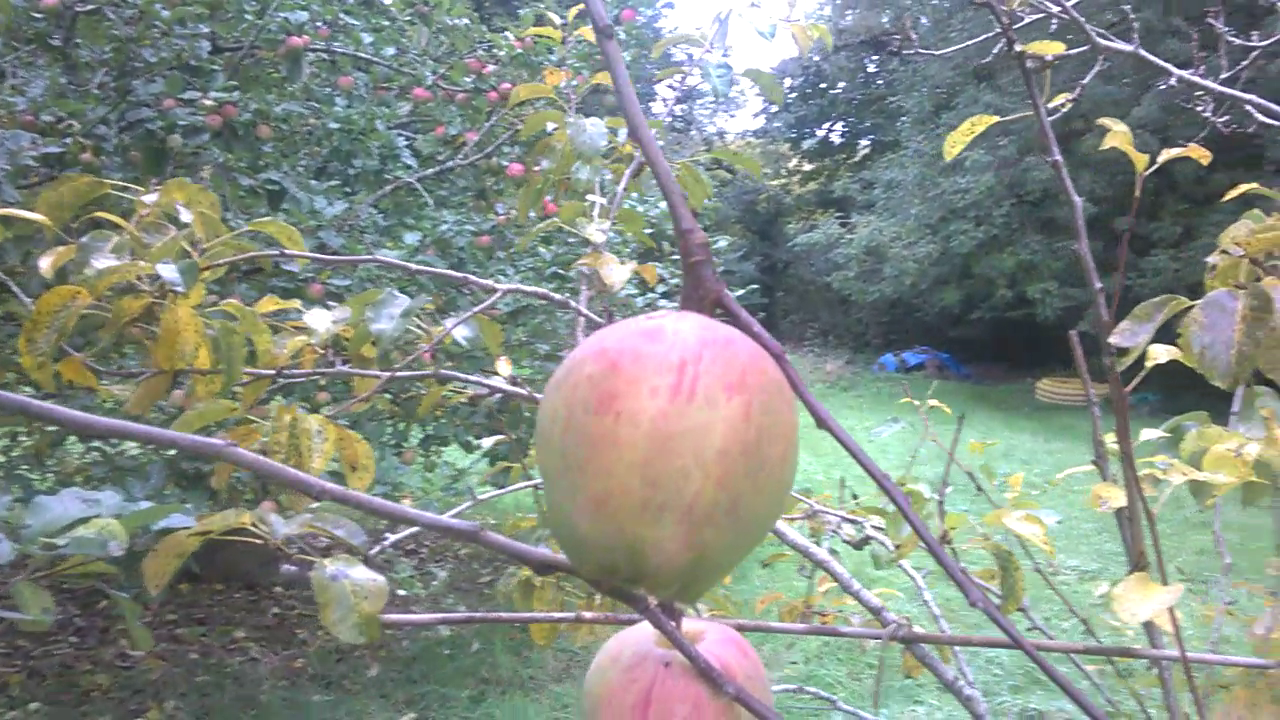

inference took: 4.571048736572266  seconds
num_detections: 100
[16 55 53 16  1 88 53 20 37 53 53 53 53 16 20 16 20 34 53 88 53 53 53 20
 53 53  1 53 53 16 16  1  1 53 16 16 35 53 38 53 20  1 16 53 53  1 38  1
 28 88 53 16 53 25 53 35 20 20 53 20 16  1 16 53 53 53 20 20 16 16 16 88
  1 53 35 16 53 28  1 16 16 53 56 16 35 88 16 28 56 53 16 16 16 16 37 53
 56  1 20 16]
 output_dict['detection_scores']  [0.4488244  0.3060485  0.14579582 0.10771912 0.10189667 0.09554869
 0.0836457  0.07696134 0.07651109 0.07546675 0.07365417 0.06872049
 0.06767267 0.06114969 0.05947378 0.05646738 0.0531143  0.0521439
 0.05203244 0.05115455 0.05020589 0.04969659 0.04911137 0.04800421
 0.04634672 0.04632267 0.04516554 0.04482126 0.04453772 0.04407945
 0.04292712 0.04281995 0.04269952 0.0426293  0.04222956 0.04221967
 0.04170525 0.04166642 0.04163447 0.04079947 0.04073793 0.04069299
 0.04043424 0.04039401 0.0403856  0.03991979 0.0398857  0.03960451
 0.03934771 0.03927827 0.03910977 0.03897557 0.03880772 0.0385

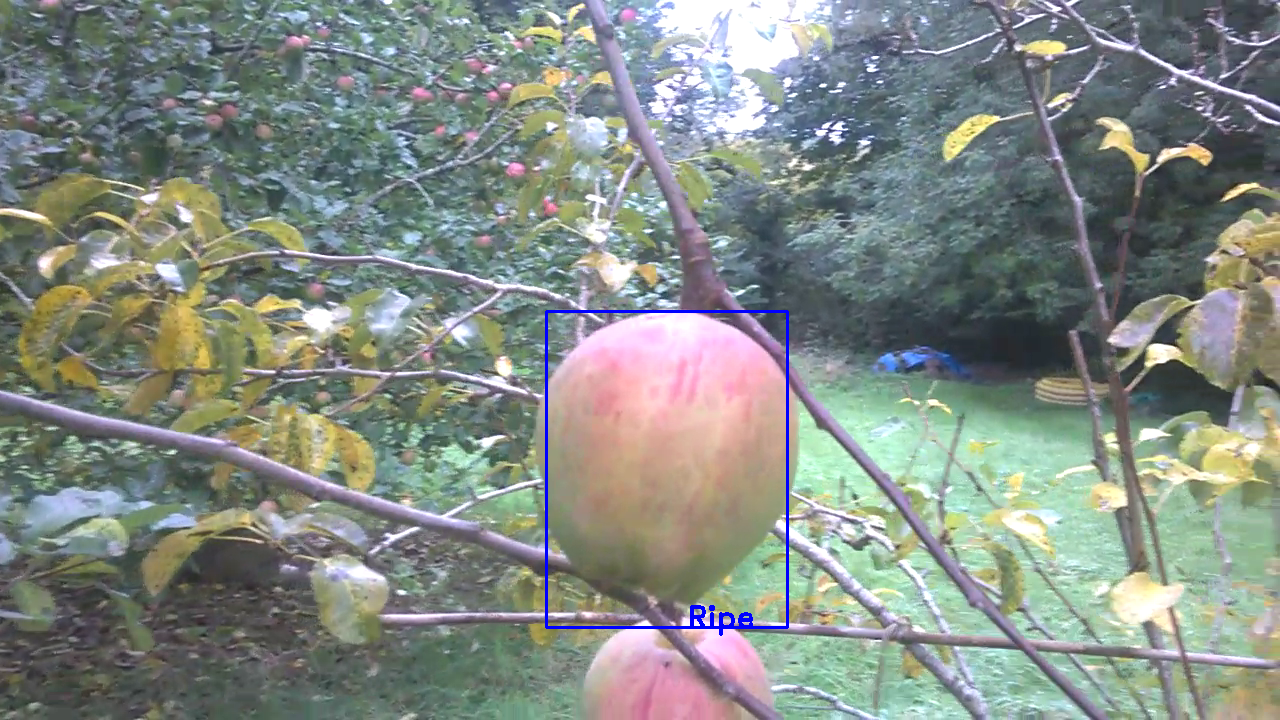

In [83]:
is_site = True
light_classifier = TLClassifier(is_site)

image = cv2.imread(base_dir+'APPLE.JPG')

from google.colab.patches import cv2_imshow
from moviepy.editor import VideoFileClip
from IPython.display import HTML #from my lane line project

clip1 = VideoFileClip(base_dir + 'APPLE_VIDEO.MP4')
frame = clip1.get_frame(3) #19

frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
cv2_imshow( frame)

probability_level = 0.13 #0.9 0.8 0.30 0.20 0.15
#processed_frame = light_classifier.get_classification(frame, probability_level)
#cv2_imshow( processed_frame)
#detected_objects = light_classifier.get_classification(frame, probability_level)
output_dict, detected_objects = light_classifier.get_classification(frame, probability_level)
pred, prob = predict_for_detected( detected_objects[0])
print(filename, ':', traffic_light_colors[pred], '- prodb:', prob, '-elapsed time:', elapsed, ' s')

#def overlay_bounding_boxes(self, image, output_dict, probability_level, preditions):
#finished_image = light_classifier.overlay_bounding_boxes(frame, detected_objects[0], prob, pred)
#finished_image =light_classifier.object_classifier.overlay_bounding_boxes(frame, detected_objects[0], prob, pred)
#finished_image =light_classifier.object_classifier.overlay_bounding_boxes(frame, detected_objects, prob, pred)
finished_image =light_classifier.object_classifier.overlay_bounding_boxes(frame, output_dict, prob, pred)

cv2_imshow( finished_image)
